### Linear Regression on the Student Performance dataset from Kaggle

[Student Performance dataset link](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

Load the dataset

In [49]:
df = pd.read_csv('../data/inputs/raw/student_performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


#### Replace the column names with their lower-case equivalents

In [50]:
rename_dict = {}
for col in df.columns:
    rename_dict[col] = col.replace(' ', '_').lower()
df = df.rename(columns=rename_dict)
df.columns

Index(['hours_studied', 'previous_scores', 'extracurricular_activities',
       'sleep_hours', 'sample_question_papers_practiced', 'performance_index'],
      dtype='object')

#### Check dataset quality, look for duplicates and missing values

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hours_studied                     10000 non-null  int64  
 1   previous_scores                   10000 non-null  int64  
 2   extracurricular_activities        10000 non-null  object 
 3   sleep_hours                       10000 non-null  int64  
 4   sample_question_papers_practiced  10000 non-null  int64  
 5   performance_index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [52]:
df[df.duplicated()]

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_question_papers_practiced,performance_index
915,9,52,No,5,9,48.0
1477,7,61,Yes,6,8,54.0
1601,5,99,No,7,5,89.0
1786,2,62,Yes,9,4,40.0
2026,5,87,Yes,6,7,74.0
...,...,...,...,...,...,...
9644,4,91,Yes,4,3,71.0
9940,8,95,No,5,2,90.0
9954,6,97,No,8,7,92.0
9966,1,41,No,7,3,12.0


Remove the duplicates


In [53]:
df = df.drop_duplicates()
df.shape

(9873, 6)

#### The target variable will be 'performance_index'

Check the remaining features for normality

In [54]:
pg.normality(df)

/home/rojo/dev/pa-mach-learn/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9873.
  res = hypotest_fun_out(*samples, **kwds)


,W,pval,normal
hours_studied,0.930694,3.148500e-55,False
previous_scores,0.953408,3.072545e-48,False
sleep_hours,0.907509,1.296007e-60,False
sample_question_papers_practiced,0.935901,8.154365e-54,False
performance_index,0.984316,1.404204e-31,False


And for outliers

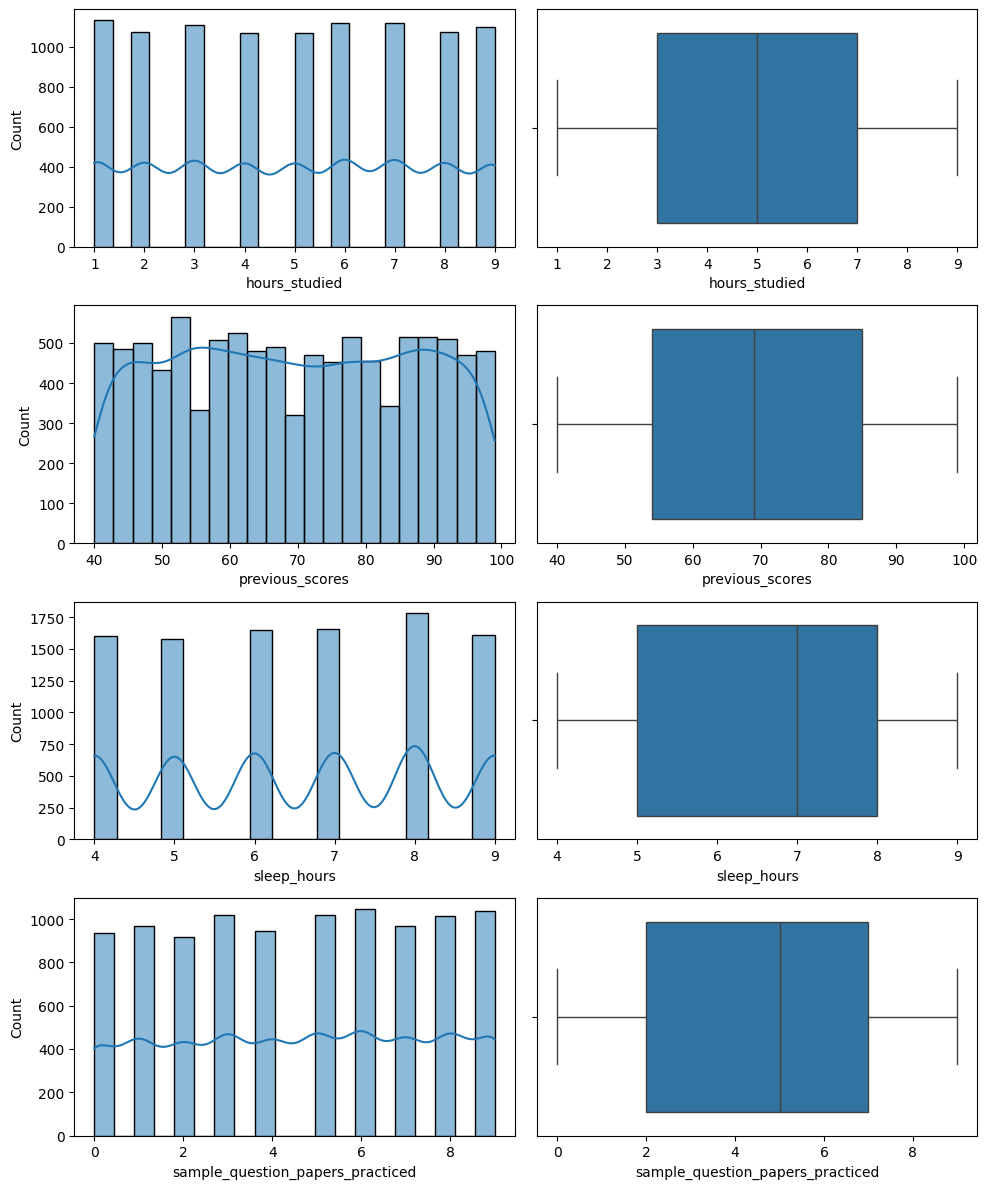

In [55]:
df_features = df.drop('performance_index', axis=1).select_dtypes('number')

fig, axes = plt.subplots(nrows=len(df_features.columns), ncols=2, figsize=(10, 12))
for index, col in enumerate(df_features.columns):
    sns.histplot(data=df_features, x=col, kde=True, ax=axes[index, 0])
    sns.boxplot(data=df_features, x=col, ax=axes[index, 1])
plt.tight_layout()
plt.show()

### Model creation. Split data into train and test sets

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['performance_index'], axis=1),
                                    df['performance_index'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print(
    "* Train set:",
    X_train.shape,
    y_train.shape,
    "\n* Test set:",
    X_test.shape,
    y_test.shape,
)

* Train set: (7898, 5) (7898,) 
* Test set: (1975, 5) (1975,)


#### Create a pipeline

We need to encode the single non-continuous feature, 'extracurricular activities'

In [56]:
df['extracurricular_activities'] = df['extracurricular_activities'].astype('category')

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

categorical_features = [col for col in df.columns if df[col].dtype == 'category']
numerical_features = [col for col in df.columns if df[col].dtype == 'int64']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

def linear_regression_pipeline():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(LinearRegression())),
        ('model', LinearRegression())
    ])
    return pipeline

linear_regression_pipeline()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['extracurricular_activities']),
                                                 ('num', StandardScaler(),
                                                  ['hours_studied',
                                                   'previous_scores',
                                                   'sleep_hours',
                                                   'sample_question_papers_practiced'])])),
                ('feature_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression())])

### Fit the pipeline to the training set

In [71]:
pipeline = linear_regression_pipeline()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['extracurricular_activities']),
                                                 ('num', StandardScaler(),
                                                  ['hours_studied',
                                                   'previous_scores',
                                                   'sleep_hours',
                                                   'sample_question_papers_practiced'])])),
                ('feature_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression())])

#### Examine the coefficients

In [72]:
def linear_model_coefficients(model, columns):
    """
    Print the intercept and coefficients of a linear model.

    Parameters:
    model (object): The trained linear model object.
    columns (array-like): The column names corresponding to the coefficients.

    Returns:
    None
    """
    print(f"* Interception: {model.intercept_}")
    coeff_df = pd.DataFrame(model.coef_, columns, columns=["Coefficient"]).sort_values(
        ["Coefficient"], key=abs, ascending=False
    )
    print("* Coefficients")
    print(coeff_df)

#### Let's see which features have been selected

In [74]:
feature_selector = pipeline.named_steps['feature_selection']
support = feature_selector.get_support()
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

feature_names[support]

array(['num__hours_studied', 'num__previous_scores'], dtype=object)

Only 2!

#### List the coefficients in order of importance

In [75]:
linear_model_coefficients(
    model=pipeline['model'],
    columns=feature_names[support]
)

* Interception: 55.163838946568745
* Coefficients
                      Coefficient
num__previous_scores    17.677174
num__hours_studied       7.427379


In [ ]:
# import regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
# we will use numpy to calculate RMSE based on MSE (mean_squared_error)
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Gets train/test sets and pipeline and evaluates the performance
    for each set (train and test) by calling regression_evaluation()
    which will evaluate the pipeline performance.

    Parameters:
    - X_train: The input features of the training set.
    - y_train: The target values of the training set.
    - X_test: The input features of the test set.
    - y_test: The target values of the test set.
    - pipeline: The regression pipeline to evaluate.

    Returns:
    None
    """

    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    """
    Gets features and target (either from train or test set) and pipeline.
    
    Args:
        X (array-like): The input features.
        y (array-like): The target values.
        pipeline (object): The trained pipeline for regression.
    
    Returns:
        None
    
    Prints the following performance metrics comparing the prediction to the target:
    - R2 Score
    - Mean Absolute Error
    - Mean Squared Error
    - Root Mean Squared Error
    """
    prediction = pipeline.predict(X)
    print("R2 Score:", r2_score(y, prediction).round(3))
    print("Mean Absolute Error:", mean_absolute_error(y, prediction).round(3))
    print("Mean Squared Error:", mean_squared_error(y, prediction).round(3))
    print(
        "Root Mean Squared Error:", np.sqrt(mean_squared_error(y, prediction)).round(3)
    )
    print("\n")

  

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    """
    Gets Train and Test set (features and target), pipeline, and adjusts dots transparency
    at scatter plot.

    Parameters:
    - X_train (array-like): Training set features.
    - y_train (array-like): Training set target.
    - X_test (array-like): Test set features.
    - y_test (array-like): Test set target.
    - pipeline (object): Trained regression pipeline.
    - alpha_scatter (float, optional): Transparency level for scatter plot dots. Default is 0.5.

    Returns:
    None

    Functionality:
    - Predicts on the train and test set using the provided pipeline.
    - Creates Actual vs Prediction scatterplots for the train and test set.
    - Draws a red diagonal line. In theory, a good regressor should predict
        close to the actual, meaning the dot should be close to the diagonal red line.
        The closer the dots are to the line, the better.
    - Displays the scatterplots.
    """
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color="red", ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color="red", ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

In [79]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(
    X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5
)

Model Evaluation 

* Train Set


AttributeError: 'float' object has no attribute 'round'